<a href="https://colab.research.google.com/github/1Stohk1/NLP/blob/main/Attention_Translator_ITA_to_ENG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural machine translation with attention

This notebook trains a sequence to sequence (seq2seq) model for Italian to English translation based on [Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025v5). This is an advanced example that assumes some knowledge of:

* Sequence to sequence models
* How the GRUs network works
* What is the Luong's attention

While this methodology is outdated this is still a good starting point to acknowledge on the effectiveness of the Enc-Dec with Attention, despite the actual SoA with the Transformers.

After training the model in this notebook, you will be able to input an Italian sentence, such as "Sei ancora a casa?", and return the English translation: "*are you still at home?*"

The resulting model is exportable as a `tf.saved_model`, so it can be used in other TensorFlow environments.

## Setup

In [1]:
%%capture

!pip install "tensorflow-text==2.8.*"

In [2]:
import numpy as np

import typing
from typing import Any, Tuple

import tensorflow as tf
import tensorflow_text as tf_text

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

import matplotlib.pyplot as plt

import os.path

In [3]:
use_builtins = True

## The data

In [4]:
# Download the file
import pathlib

path_to_zip = tf.keras.utils.get_file(
    'ita.zip', origin='https://drive.google.com/u/0/uc?id=1KoF4vyAHw6hjXdkJ9j7ybAWeKYS1osW7&export=download',
    extract=True)

path_to_file = pathlib.Path(path_to_zip).parent/'ita.txt'

In [5]:
def load_data(path):
  text = path.read_text(encoding='utf-8')

  lines = text.splitlines()
  pairs = [line.split('\t') for line in lines]

  inp = [inp for targ, inp in pairs]
  targ = [targ for targ, inp in pairs]

  return targ, inp

In [6]:
from sklearn.model_selection import train_test_split

targ, inp = load_data(path_to_file)

targ_train, targ_test, inp_train, inp_test = train_test_split(targ, inp, test_size=0.05, random_state=42)

### Create a tf.data dataset

From these arrays of strings you can create a `tf.data.Dataset` of strings that shuffles and batches them efficiently:

In [7]:
BUFFER_SIZE = len(inp)
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices((inp_train, targ_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

### Text preprocessing

The goal of this project is to train a model that is exportable, giving the possibility to load the weights and
translate sentences declaring just the class of Train_Translator and Translator itself. To make that exported model
useful it should take `tf.string` inputs, and return `tf.string` outputs: All the text processing happens inside the model.

#### Standardization

The model is dealing with multilingual text with a limited vocabulary. So it will be important to standardize the input text.

The first step is Unicode normalization to split accented characters and replace compatibility characters with their ASCII equivalents.

The `tensorflow_text` package contains a unicode normalize operation:

Unicode normalization will be the first step in the text standardization function:

In [8]:
def tf_lower_and_split_punct(text):
  # Split accecented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

#### Text Vectorization

This standardization function will be wrapped up in a `tf.keras.layers.TextVectorization` layer which will handle the vocabulary extraction and conversion of input text to sequences of tokens.

In [9]:
max_vocab_size = 5000

input_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)
input_text_processor.adapt(inp)

The `TextVectorization` layer and many other preprocessing layers have an `adapt` method. This method reads one epoch of the training data, and works a lot like `Model.fix`. This `adapt` method initializes the layer based on the data. Here it determines the vocabulary:  

That's the Italian `TextVectorization` layer, now build and `.adapt()` the English one:

In [10]:
output_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

output_text_processor.adapt(targ)

Before getting into it define a few constants for the model:

In [11]:
embedding_dim = 512
units = 1536

### The encoder
1. Takes a list of token IDs (from `input_text_processor`).
3. Looks up an embedding vector for each token (Using a `layers.Embedding`).
4. Processes the embeddings into a new sequence (Using a `layers.GRU`).
5. Returns:
  * The processed sequence. This will be passed to the attention head.
  * The internal state. This will be used to initialize the decoder


In [12]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, input_vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()
    self.enc_units = enc_units
    self.input_vocab_size = input_vocab_size

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,
                                               embedding_dim)

    # The GRU RNN layer processes those vectors sequentially.
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   # Return the sequence and state
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_normal')  # glorot_uniform

  def call(self, tokens, state=None):

    # 2. The embedding layer looks up the embedding for each token.
    vectors = self.embedding(tokens)

    # 3. The GRU processes the embedding sequence.
    output, state = self.gru(vectors, initial_state=state)

    # 4. Returns the new sequence and its state.
    return output, state

The encoder returns its internal state so that its state can be used to initialize the decoder.

It's also common for an RNN to return its state so that it can process a sequence over multiple calls. You'll see more of that building the decoder.

### The attention head
Makes focus on the words we're dealing from the prospective of the decoder.
It handles:
1. The query or the words that we have to translate, it is also the output state of the decoder
2. The value are the words present in the vocabulary of the target language, that we can match with the closest
embedding vector in the source language
3. The mask, the effective words that compose the actual sentence, remember that we're dealing with a matrix that is NxM,
where N are the number of sentences and M is the longest sentence

The attention takes a sequence of vectors as input for each example and returns an "attention" vector for each example. This attention layer is similar to a `layers.GlobalAveragePoling1D` but the attention layer performs a _weighted_ average.

Let's look at how this works:

<img src="resources/attention_equation_1.jpg" alt="attention equation 1" width="800">

<img src="resources/attention_equation_2.jpg" alt="attention equation 2" width="800">

Where:

* $s$ is the encoder index.
* $t$ is the decoder index.
* $\alpha_{ts}$ is the attention weights.
* $h_s$ is the sequence of encoder outputs being attended to (the attention "key" and "value" in transformer terminology).
* $h_t$ is the the decoder state attending to the sequence (the attention "query" in transformer terminology).
* $c_t$ is the resulting context vector.
* $a_t$ is the final output combining the "context" and "query".

The equations:

1. Calculates the attention weights, $\alpha_{ts}$, as a softmax across the encoder's output sequence.
2. Calculates the context vector as the weighted sum of the encoder outputs.

Last is the $score$ function. Its job is to calculate a scalar logit-score for each key-query pair. There are two common approaches:

<img src="resources/attention_equation_4.jpg" alt="attention equation 4" width="800">

In [13]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super().__init__()
    # For Eqn. (4), the  Bahdanau attention
    self.W1 = tf.keras.layers.Dense(units, use_bias=False)
    self.W2 = tf.keras.layers.Dense(units, use_bias=False)

    self.attention = tf.keras.layers.AdditiveAttention()

  def call(self, query, value, mask):

    # From Eqn. (4), `W1@ht`.
    w1_query = self.W1(query)

    # From Eqn. (4), `W2@hs`.
    w2_key = self.W2(value)

    query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
    value_mask = mask

    context_vector, attention_weights = self.attention(
        inputs = [w1_query, value, w2_key],
        mask=[query_mask, value_mask],
        return_attention_scores = True,
    )

    return context_vector, attention_weights

### The decoder
Here is the `Decoder` class and its initializer. The initializer creates all the necessary layers.

In [14]:
class DecoderInput(typing.NamedTuple):
  new_tokens: Any
  enc_output: Any
  mask: Any

class DecoderOutput(typing.NamedTuple):
  logits: Any
  attention_weights: Any

class Decoder(tf.keras.layers.Layer):
  def __init__(self, output_vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.output_vocab_size = output_vocab_size
    self.embedding_dim = embedding_dim

    # For Step 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                               embedding_dim)

    # For Step 2. The RNN keeps track of what's been generated so far.
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_normal')

    # For step 3. The RNN output will be the query for the attention layer.
    self.attention = BahdanauAttention(self.dec_units)

    # For step 4. Eqn. (3): converting `ct` to `at`
    self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                    use_bias=False)

    # For step 5. This fully connected layer produces the logits for each
    # output token.
    self.fc = tf.keras.layers.Dense(self.output_vocab_size)

  def call(self,
         inputs: DecoderInput,
         state=None) -> Tuple[DecoderOutput, tf.Tensor]:

    # Step 1. Lookup the embeddings
    vectors = self.embedding(inputs.new_tokens)

    # Step 2. Process one step with the RNN
    rnn_output, state = self.gru(vectors, initial_state=state)

    # Step 3. Use the RNN output as the query for the attention over the
    # encoder output.
    context_vector, attention_weights = self.attention(
        query=rnn_output, value=inputs.enc_output, mask=inputs.mask)
    # Step 4. Eqn. (3): Join the context_vector and rnn_output
    context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

    # Step 4. Eqn. (3): `at = tanh(Wc@[ct; ht])`
    attention_vector = self.Wc(context_and_rnn_output)

    # Step 5. Generate logit predictions:
    logits = self.fc(attention_vector)

    return DecoderOutput(logits, attention_weights), state

## Training

Now that you have all the model components, it's time to start training the model. You'll need:

- A loss function and optimizer to perform the optimization.
- A training step function defining how to update the model for each input/target batch.
- A training loop to drive the training and save checkpoints.

### Define the loss function

In [15]:
class MaskedLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'masked_loss'
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

  def __call__(self, y_true, y_pred):

    # Calculate the loss for each item in the batch.
    loss = self.loss(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, tf.float32)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)

### Implement the training step

Start with a model class, the training process will be implemented as the `train_step` method on this model. See [Customizing fit](https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit) for details.

Here the `train_step` method is a wrapper around the `_train_step` implementation which will come later. This wrapper includes a switch to turn on and off `tf.function` compilation, to make debugging easier.

In [16]:
class TrainTranslator(tf.keras.Model):
  def __init__(self, embedding_dim, units,
               input_text_processor,
               output_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(input_text_processor.vocabulary_size(),
                      embedding_dim, units)
    decoder = Decoder(output_text_processor.vocabulary_size(),
                      embedding_dim, units)

    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor

  @tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                               tf.TensorSpec(dtype=tf.string, shape=[None])]])
  def train_step(self, inputs):
    input_text, target_text = inputs  

    (input_tokens, input_mask,
    target_tokens, target_mask) = self._preprocess(input_text, target_text)

    max_target_length = tf.shape(target_tokens)[1]

    with tf.GradientTape() as tape:
      # Encode the input
      enc_output, enc_state = self.encoder(input_tokens)

      # Initialize the decoder's state to the encoder's final state.
      # This only works if the encoder and decoder have the same number of
      # units.
      dec_state = enc_state
      loss = tf.constant(0.0)

      for t in tf.range(max_target_length-1):
        # Pass in two tokens from the target sequence:
        # 1. The current input to the decoder.
        # 2. The target for the decoder's next prediction.
        new_tokens = target_tokens[:, t:t+2]
        step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                              enc_output, dec_state)
        loss = loss + step_loss

      # Average the loss over all non padding tokens.
      average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

    # Apply an optimization step
    variables = self.trainable_variables 
    gradients = tape.gradient(average_loss, variables)
    self.optimizer.apply_gradients(zip(gradients, variables))

    # Return a dict mapping metric names to current value
    return {'batch_loss': average_loss}

  def _preprocess(self, input_text, target_text):
    # Convert the text to token IDs
    input_tokens = self.input_text_processor(input_text)
    target_tokens = self.output_text_processor(target_text)

    # Convert IDs to masks.
    input_mask = input_tokens != 0

    target_mask = target_tokens != 0

    return input_tokens, input_mask, target_tokens, target_mask

  def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
    input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

    # Run the decoder one step.
    decoder_input = DecoderInput(new_tokens=input_token,
                                enc_output=enc_output,
                                mask=input_mask)

    dec_result, dec_state = self.decoder(decoder_input, state=dec_state)

    # `self.loss` returns the total for non-padded tokens
    y = target_token
    y_pred = dec_result.logits
    step_loss = self.loss(y, y_pred)

    return step_loss, dec_state

Overall the implementation for the `Model.train_step` method is as follows:

1. Receive a batch of `input_text, target_text` from the `tf.data.Dataset`.
2. Convert those raw text inputs to token-embeddings and masks. 
3. Run the encoder on the `input_tokens` to get the `encoder_output` and `encoder_state`.
4. Initialize the decoder state and loss. 
5. Loop over the `target_tokens`:
   1. Run the decoder one step at a time.
   2. Calculate the loss for each step.
   3. Accumulate the average loss.
6. Calculate the gradient of the loss and use the optimizer to apply updates to the model's `trainable_variables`.

The `_loop_step` method, added below, executes the decoder and calculates the incremental loss and new decoder state (`dec_state`).

In [17]:
train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor)

# Configure the loss and optimizer
train_translator.compile(
    optimizer=tf.optimizers.Adamax(),
    loss=MaskedLoss(),
)

### Train the model

While there's nothing wrong with writing your own custom training loop, implementing the `Model.train_step` method, as in the previous section, allows you to run `Model.fit` and avoid rewriting all that boiler-plate code. 

This tutorial only trains for a couple of epochs, so use a `callbacks.Callback` to collect the history of batch losses, for plotting:

In [30]:
from datetime import datetime

class BatchLogs(tf.keras.callbacks.Callback):
  def __init__(self, key):
    self.key = key
    self.logs = []

  def on_train_batch_end(self, n, logs):  
    self.logs.append(logs[self.key])

batch_loss = BatchLogs('batch_loss')


checkpoint_path = 'checkpoints/training' +datetime.now().strftime("%d_%m %H-%M")+'/cp'
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='batch_loss',
    mode='min',
    save_best_only=True,
    verbose=1)

### Starting the training phase


In [31]:
import time

start_time = time.time()
train_translator.fit(dataset.take(100), epochs=2,
                     callbacks=[batch_loss, cp_callback])
total_time = time.time() - start_time

Epoch 1/2
100/100 [==============================] - ETA: 0s - batch_loss: 2.8811  

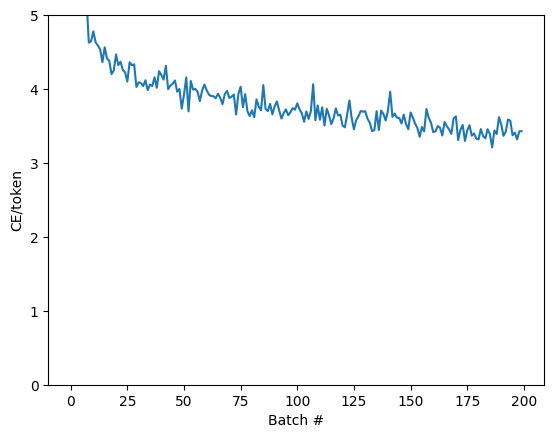

In [20]:
plot_name = 'resources/lastplot.png'
plt.plot(batch_loss.logs)
plt.ylim([0, 5])
plt.xlabel('Batch #')
plt.ylabel('CE/token')
plt.savefig(plot_name)

## Translate

Now that the model is trained, implement a function to execute the full `text => text` translation.

For this the model needs to invert the `text => token IDs` mapping provided by the `output_text_processor`. It also needs to know the IDs for special tokens. This is all implemented in the constructor for the new class. The implementation of the actual translate method will follow.

Overall this is similar to the training loop, except that the input to the decoder at each time step is a sample from the decoder's last prediction.

In [21]:
class Translator(tf.Module):

  def __init__(self, encoder, decoder, input_text_processor,
               output_text_processor):
    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor

    self.output_token_string_from_index = (
        tf.keras.layers.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(),
            mask_token='',
            invert=True))

    # The output should never generate padding, unknown, or start.
    index_from_string = tf.keras.layers.StringLookup(
        vocabulary=output_text_processor.get_vocabulary(), mask_token='')
    token_mask_ids = index_from_string(['', '[UNK]', '[START]']).numpy()

    token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=bool)
    token_mask[np.array(token_mask_ids)] = True
    self.token_mask = token_mask

    self.start_token = index_from_string(tf.constant('[START]'))
    self.end_token = index_from_string(tf.constant('[END]'))

  def tokens_to_text(self, result_tokens):
    result_text_tokens = self.output_token_string_from_index(result_tokens)

    result_text = tf.strings.reduce_join(result_text_tokens,
                                        axis=1, separator=' ')

    result_text = tf.strings.strip(result_text)
    return result_text

  def sample(self, logits, temperature):
    token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]

    # Set the logits for all masked tokens to -inf, so they are never chosen.
    logits = tf.where(self.token_mask, -np.inf, logits)

    if temperature == 0.0:
      new_tokens = tf.argmax(logits, axis=-1)
    else: 
      logits = tf.squeeze(logits, axis=1)
      new_tokens = tf.random.categorical(logits/temperature,
                                          num_samples=1)
    
    return new_tokens
      
  @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
  def tf_translate(self,
                        input_text,
                        *,
                        max_length=50,
                        return_attention=True,
                        temperature=1.0):

    batch_size = tf.shape(input_text)[0]

    # Encode the input
    input_tokens = self.input_text_processor(input_text)
    enc_output, enc_state = self.encoder(input_tokens)
    # Initialize the decoder
    dec_state = enc_state
    new_tokens = tf.fill([batch_size, 1], self.start_token)
    
    # Initialize the accumulators
    result_tokens = tf.TensorArray(tf.int64, size=1, dynamic_size=True)
    attention = tf.TensorArray(tf.float32, size=1, dynamic_size=True)
    done = tf.zeros([batch_size, 1], dtype=tf.bool)

    for t in tf.range(max_length):
      dec_input = DecoderInput(
          new_tokens=new_tokens, enc_output=enc_output, mask=(input_tokens != 0))

      dec_result, dec_state = self.decoder(dec_input, state=dec_state)

      attention = attention.write(t, dec_result.attention_weights)

      new_tokens = self.sample(dec_result.logits, temperature)

      # If a sequence produces an `end_token`, set it `done`
      done = done | (new_tokens == self.end_token)
      # Once a sequence is done it only produces 0-padding.
      new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

      # Collect the generated tokens
      result_tokens = result_tokens.write(t, new_tokens)

      if tf.reduce_all(done):
        break

    # Convert the list of generated token ids to a list of strings.
    result_tokens = result_tokens.stack()
    result_tokens = tf.squeeze(result_tokens, -1)
    result_tokens = tf.transpose(result_tokens, [1, 0])

    result_text = self.tokens_to_text(result_tokens)

    if return_attention:
      attention_stack = attention.stack()

      attention_stack = tf.squeeze(attention_stack, 2)

      attention_stack = tf.transpose(attention_stack, [1, 0, 2])

      return {'text': result_text, 'attention': attention_stack}
    else:
      return {'text': result_text}

In [22]:
translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)

# Bleu Score

Now we want to find out how our model is performing using the Bleu score, with progressive N-Grams from 1 till 4. The score will be compared with other kind of model to find out which is the best one in the translation of sentences.

In [23]:
score = 0
score1 = 0

import evaluate

bleu = sentence_bleu
cc = SmoothingFunction()

bleu1 = evaluate.load("bleu")

reference = ''
candidate = ''

for target, source in zip(targ_test, inp_test):
  source_constant = tf.constant([source])
  result = translator.tf_translate(source_constant)
  candidate = result['text'][0].numpy().decode()

  # Removing punctuation
  reference = target.replace(".", "").replace(",", "")
  candidate = candidate.replace(".", "").replace(",", "")
  # Lower the capitals
  reference = reference.lower()
  candidate = candidate.lower()



  score += bleu(reference.split(" "), candidate.split(" "), smoothing_function=cc.method4, weights=(0.5, 0.25, 0.25, 0))
  try:
    score1 += bleu1.compute(predictions=candidate, references=reference)["bleu"]
  except:
    score1 += 0

print(reference)
print(candidate)
score = score/len(targ_test)
score1 = score/len(targ_test)
print("Evaluation made with the naive Bleu: "+score)
print("Evaluation made with the evaluation Bleu: "+score1)

#### Notify

These are the functions used to awake the Telegram Bot and send a Notification on the smartphone

In [24]:
import platform
import telepot

#Telegram API
token = '5453584270:AAHIZnD7IoHRWzSmzQR_yGU2T-676IVmSoo'
theUrl = "https://api.telegram.org/bot"+token+"/sendMessage"
chris = "806724607"
giacomo = "149504493"
who = [chris, giacomo]

pc_name = platform.node()

def sendMessage(text=""):
    import json
    import requests
    for listener in who:
        data = {'chat_id': listener, 'disable_notification': 'false', 'text': text}
        headers = {'Content-type': 'application/json', 'Accept': 'text/plain'}
        requests.post(theUrl, data=json.dumps(data, ensure_ascii=True), headers=headers)

def sendFile(file):
    bot = telepot.Bot(token)
    for listener in who:
        f = open(file, 'rb')
        bot.sendDocument(listener, f)
        f.close()

text = """
💻 Worker: """+pc_name+"""
✨ Finished training for the seq2seq + BahdanauAttention✨
🧠 Model: """+checkpoint_dir+"""
🕒 Total time: """ + str(np.round(total_time/3600, 2)) +"H"+"""
📈 Best result: """ + str(batch_loss.logs[-1]) + """
📐 Bleu score: """ + str(np.around(score, 4)) + """
🔍 Params """ + "nothing special" + """
"""

sendMessage(text)
sendFile(plot_name)

## Import from Checkpoint

Here we are loading the checkpoint in the Train Translator model, the same class in which we trained the Encoder and Decoder.
Then we make a new Translator object from the loaded Encoder and Decoder.
First we must create a new model that will load the weights, then we use the loaded model to initialize a new Translator.

In [36]:
source_sentence = tf.constant([
    # This is my life.
    'Questa è casa mia.'
])
# Translation of the sentence with the trained model
trained_result = translator.tf_translate(source_sentence)

# Initialization of the model
loaded_train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor)
# Configure the loss and optimizer
loaded_train_translator.compile(
    optimizer=tf.optimizers.Adamax(),
    loss=MaskedLoss())
# Loading of weight
loaded_train_translator.load_weights(checkpoint_path)
# Initialization of the translator based on the loaded encoder and decoder
loaded_translator = Translator(
    encoder=loaded_train_translator.encoder,
    decoder=loaded_train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor)
# Translation of the sentence with the loaded model
loaded_result = loaded_translator.tf_translate(source_sentence)

print('Modello appena trainato traduce con: '+trained_result['text'][0].numpy().decode())
print('Modello caricato con checkpoint traduce con: '+loaded_result['text'][0].numpy().decode())

# Comparison of the batch loss
train_translator.fit(dataset.take(100), epochs=1,
                     callbacks=[batch_loss])
loaded_train_translator.fit(dataset.take(100), epochs=1,
                     callbacks=[batch_loss])

Modello appena trainato traduce con: why have you agree about christmas ?
Modello caricato con checkpoint traduce con: do you like to solve home ?


INFO:tensorflow:Assets written to: translator\assets


INFO:tensorflow:Assets written to: translator\assets


Modello caricato con saved_model traduce con: do you busy go alone ?
100/100 [==============================] - ETA: 0s - batch_loss: 2.5386 